In [194]:
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import pacf
import xgboost as xgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit

In [195]:
X_train = pd.read_csv('../challenge_data/X_train.csv')
Y_train = pd.read_csv('../challenge_data/Y_train.csv')
X_test = pd.read_csv('../challenge_data/X_test.csv')

In [196]:
from Util.tools import *
X_train_clean = fill_missing_with_average(X_train)
X_test_clean = fill_missing_with_average(X_test)

In [197]:
#drop those cols according to EDA
X_train_clean=X_train_clean.drop(["DE_FR_EXCHANGE","DE_NET_IMPORT","FR_NET_IMPORT"],axis=1)
X_test_clean=X_test_clean.drop(["DE_FR_EXCHANGE","DE_NET_IMPORT","FR_NET_IMPORT"],axis=1)

In [198]:
#Split into DE & FR
X_train_de = X_train_clean[X_train_clean['COUNTRY'] == 'DE']
X_test_de = X_test_clean[X_test_clean['COUNTRY'] == 'DE']
X_train_fr = X_train_clean[X_train_clean['COUNTRY'] == 'FR']
X_test_fr = X_test_clean[X_test_clean['COUNTRY'] == 'FR']

In [199]:
# merge TARGET

X_train_de = pd.merge(X_train_de, Y_train, on='ID', how='inner').sort_values('DAY_ID')
X_train_fr = pd.merge(X_train_fr, Y_train, on='ID', how='inner').sort_values('DAY_ID')

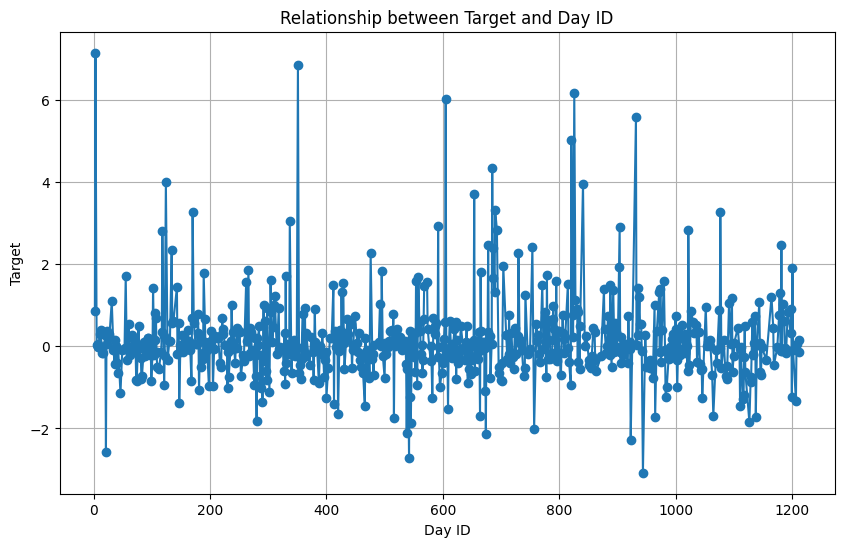

In [200]:
plt.figure(figsize=(10, 6))
plt.plot(X_train_de['DAY_ID'], X_train_de['TARGET'], marker='o', linestyle='-')
plt.xlabel('Day ID')
plt.ylabel('Target')
plt.title('Relationship between Target and Day ID')
plt.grid(True)
plt.show()

In [201]:
def calculate_compounded_price(df, sort_column):
    df_sorted = df.sort_values(by=sort_column)
    compounded_price = df_sorted['TARGET'].cumsum()
    return df_sorted[sort_column], compounded_price

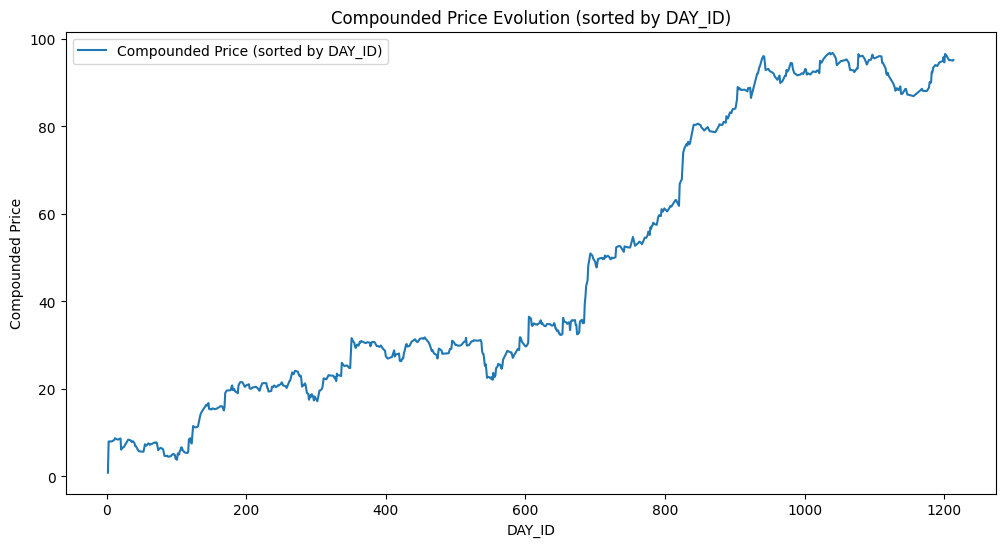

In [202]:
day_id_sorted, compounded_price_day_id = calculate_compounded_price(X_train_de, 'DAY_ID')
plt.figure(figsize=(12, 6))
plt.plot(day_id_sorted, compounded_price_day_id, label='Compounded Price (sorted by DAY_ID)')
plt.xlabel('DAY_ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by DAY_ID)')
plt.legend()
plt.show()

In [203]:
X_train_de = X_train_de.drop('COUNTRY', axis=1).set_index('DAY_ID').sort_values('DAY_ID')

X_train_fr = X_train_fr.drop('COUNTRY', axis=1).set_index('DAY_ID').sort_values('DAY_ID')


In [204]:
X_test_de = X_test_de.drop('COUNTRY', axis=1).set_index('DAY_ID').sort_values('DAY_ID')

X_test_fr = X_test_fr.drop('COUNTRY', axis=1).set_index('DAY_ID').sort_values('DAY_ID')

In [213]:
X_train_de['TARGET_prev_day'] = X_train_de['TARGET'].shift(1)
X_train_de['TARGET_next_day'] = X_train_de['TARGET'].shift(-1)

X_train_fr['TARGET_prev_day'] = X_train_fr['TARGET'].shift(1)
X_train_fr['TARGET_next_day'] = X_train_fr['TARGET'].shift(-1)

de_target_mean = X_train_de['TARGET'].mean()
fr_target_mean = X_train_fr['TARGET'].mean()

window_size = 14  # Example window size, can be adjusted
X_train_de['TARGET_MA'] = X_train_de['TARGET'].rolling(window=window_size, min_periods=1).mean()
X_train_fr['TARGET_MA'] = X_train_fr['TARGET'].rolling(window=window_size, min_periods=1).mean()

In [218]:
def find_nearest_dates(test_date, train_dates):
    # 计算差异
    differences = np.abs(train_dates - test_date)
    # 找到最小差异的7个索引
    nearest_indices = differences.argsort()[:7]
    return nearest_indices

# 创建一个空的列表来保存新特征的值
new_feature_values = []

# 遍历 X_test_de 中的每个 DAY_ID
for day_id in X_test_de.index:
    # 找到 X_train_de 中最接近的7个 DAY_ID
    nearest_indices = find_nearest_dates(day_id, X_train_de.index)
    # 计算这些 DAY_ID 对应的 TARGET_MA 值的平均值
    nearest_values_mean = X_train_de.iloc[nearest_indices]['TARGET_MA'].mean()
    # 将计算出的平均值添加到列表中
    new_feature_values.append(nearest_values_mean)

# 将新特征的值添加到 X_test_de DataFrame 中
X_test_de['TARGET_MA'] = new_feature_values

In [219]:
# 创建一个空的列表来保存新特征的值
new_feature_values_fr = []

# 遍历 X_test_fr 中的每个 DAY_ID
for day_id in X_test_fr.index:
    # 找到 X_train_fr 中最接近的7个 DAY_ID
    nearest_indices = find_nearest_dates(day_id, X_train_fr.index)
    # 计算这些 DAY_ID 对应的 TARGET_MA 值的平均值
    nearest_values_mean = X_train_fr.iloc[nearest_indices]['TARGET_MA'].mean()
    # 将计算出的平均值添加到列表中
    new_feature_values_fr.append(nearest_values_mean)

# 将新特征的值添加到 X_test_fr DataFrame 中
X_test_fr['TARGET_MA'] = new_feature_values_fr

In [207]:
X_train_de.fillna(de_target_mean, inplace=True)
X_train_fr.fillna(fr_target_mean, inplace=True)

In [221]:
X_test_fr.head(15).T

DAY_ID,4,6,9,10,13,17,19,24,30,32,33,35,39,43,44
ID,1626.000000,1778.000000,1966.000000,1125.000000,2018.000000,1087.000000,1154.000000,1720.000000,2028.000000,1785.000000,1585.000000,1112.000000,1294.000000,1687.000000,1469.000000
DE_CONSUMPTION,0.944117,0.120788,1.056973,0.306463,-0.138870,0.209703,1.382369,0.143362,-0.283800,0.130147,0.024344,0.321186,0.056200,1.786274,-0.525544
FR_CONSUMPTION,0.203547,-0.744840,0.535641,0.801805,-0.702079,-0.814539,2.089408,-0.524899,-0.533887,-0.777049,-0.743239,-0.518141,-0.817071,1.744546,-0.979650
FR_DE_EXCHANGE,-0.372743,1.195940,-0.989874,-0.344529,0.521880,-0.439779,-0.744530,1.030414,-0.517402,0.897493,0.808589,0.148289,1.271258,-0.869430,1.654935
DE_NET_EXPORT,0.656335,-1.670709,0.091679,0.902401,-1.067974,-0.243703,1.067457,-1.005184,-0.947273,-1.462833,-1.282167,0.754927,-1.600728,1.391312,-1.330629
FR_NET_EXPORT,0.519380,1.164429,-1.072153,-0.367998,-0.670168,-0.045395,-1.162274,0.832404,-1.441313,1.066893,-1.039969,0.530188,0.859998,-0.544104,1.411294
DE_GAS,0.451085,1.524895,1.107820,0.263876,1.326792,-0.617943,2.300959,0.640496,1.088557,0.504977,1.508235,0.120841,1.382169,1.815562,0.500800
FR_GAS,0.865857,-0.395402,1.438079,0.831329,0.128697,-0.396121,1.860054,-0.455046,0.224605,-0.325888,0.311523,0.021849,-0.082002,1.553767,-1.277610
DE_COAL,-0.752504,-0.079164,0.591335,-0.010012,-0.601360,0.349703,2.363781,-1.064691,-0.134109,-0.138962,0.373618,1.027381,-0.445720,-0.301178,-1.367632
FR_COAL,-0.782998,-0.794950,-0.184626,0.548601,-0.676503,-0.439568,-0.794950,-0.784396,-0.777006,-0.608671,0.055126,0.055137,-0.775335,-0.363431,-0.776754


In [155]:
from scipy.stats import spearmanr

correlations = {}
for column in X_train_de.columns:
    # 计算Spearman相关系数和p值
    corr, _ = spearmanr(X_train_de[column], X_train_de['TARGET'])
    correlations[column] = corr

# 将相关系数转换为数据框并按其绝对值排序
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df['Absolute_Correlation'] = corr_df['Correlation'].abs()
sorted_corr_df = corr_df.sort_values('Absolute_Correlation', ascending=False)

# 显示排序后的相关系数数据框
print(sorted_corr_df)


             Feature  Correlation  Absolute_Correlation
31            TARGET     1.000000              1.000000
20  DE_RESIDUAL_LOAD     0.324335              0.324335
5      DE_NET_EXPORT    -0.306204              0.306204
17        DE_WINDPOW    -0.300933              0.300933
7             DE_GAS     0.253410              0.253410
11          DE_HYDRO     0.217900              0.217900
18        FR_WINDPOW    -0.199820              0.199820
9            DE_COAL     0.142054              0.142054
24           DE_WIND    -0.141290              0.141290
19        DE_LIGNITE     0.124605              0.124605
34         TARGET_MA     0.124338              0.124338
4     FR_DE_EXCHANGE     0.094402              0.094402
25           FR_WIND    -0.088557              0.088557
8             FR_GAS     0.072784              0.072784
2     DE_CONSUMPTION    -0.071736              0.071736
23           FR_RAIN    -0.068166              0.068166
12          FR_HYDRO     0.058362              0

/Users/zhengwan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [227]:
selected_features = sorted_corr_df[sorted_corr_df['Absolute_Correlation'] >= 0.05]['Feature']

features_selected_de = selected_features.tolist()
features_selected_de.remove('TARGET')  # 从列表中删除 'TARGET'
print("Selected Features for DE:")
print(features_selected_de)

Selected Features for DE:
['CARBON_RET', 'GAS_RET', 'FR_WINDPOW', 'TARGET_MA', 'DE_HYDRO', 'DE_WINDPOW', 'DE_NET_EXPORT', 'FR_HYDRO', 'FR_COAL', 'DE_RAIN', 'COAL_RET', 'DE_RESIDUAL_LOAD', 'DE_CONSUMPTION']


In [157]:
correlations = {}
for column in X_train_fr.columns:
    corr, _ = spearmanr(X_train_fr[column], X_train_fr['TARGET'])
    correlations[column] = corr

corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df['Absolute_Correlation'] = corr_df['Correlation'].abs()
sorted_corr_df = corr_df.sort_values('Absolute_Correlation', ascending=False)


print(sorted_corr_df)

             Feature  Correlation  Absolute_Correlation
31            TARGET     1.000000              1.000000
30        CARBON_RET     0.191809              0.191809
28           GAS_RET     0.148956              0.148956
18        FR_WINDPOW    -0.121530              0.121530
34         TARGET_MA     0.094666              0.094666
11          DE_HYDRO     0.087350              0.087350
17        DE_WINDPOW    -0.080487              0.080487
5      DE_NET_EXPORT    -0.076034              0.076034
12          FR_HYDRO     0.071709              0.071709
10           FR_COAL     0.068084              0.068084
22           DE_RAIN    -0.059819              0.059819
29          COAL_RET     0.057616              0.057616
20  DE_RESIDUAL_LOAD     0.053790              0.053790
2     DE_CONSUMPTION    -0.051604              0.051604
25           FR_WIND    -0.046042              0.046042
27           FR_TEMP    -0.040281              0.040281
15          DE_SOLAR     0.038168              0

/Users/zhengwan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [226]:

selected_features = sorted_corr_df[sorted_corr_df['Absolute_Correlation'] >= 0.05]['Feature']

features_selected_fr = selected_features.tolist()
features_selected_fr.remove('TARGET')  
print("Selected Features for FR:")
print(features_selected_fr)

Selected Features for FR:
['CARBON_RET', 'GAS_RET', 'FR_WINDPOW', 'TARGET_MA', 'DE_HYDRO', 'DE_WINDPOW', 'DE_NET_EXPORT', 'FR_HYDRO', 'FR_COAL', 'DE_RAIN', 'COAL_RET', 'DE_RESIDUAL_LOAD', 'DE_CONSUMPTION']


In [228]:
# 创建 FR 和 DE 特征集合
features_fr_set = set(features_selected_fr)
features_de_set = set(features_selected_de)

# 确定只在 FR 中出现的特征
only_in_fr = features_fr_set - features_de_set

# 确定只在 DE 中出现的特征
only_in_de = features_de_set - features_fr_set

# 确定共同出现在 FR 和 DE 中的特征
common_features = features_fr_set.intersection(features_de_set)

print("特征只在 FR 中出现:", only_in_fr)
print("特征只在 DE 中出现:", only_in_de)
print("共同出现在 FR 和 DE 中的特征:", common_features)


特征只在 FR 中出现: set()
特征只在 DE 中出现: set()
共同出现在 FR 和 DE 中的特征: {'DE_RESIDUAL_LOAD', 'DE_HYDRO', 'DE_CONSUMPTION', 'GAS_RET', 'DE_WINDPOW', 'COAL_RET', 'FR_COAL', 'CARBON_RET', 'FR_WINDPOW', 'DE_RAIN', 'TARGET_MA', 'FR_HYDRO', 'DE_NET_EXPORT'}


In [229]:
from sklearn.model_selection import train_test_split


X_trainde, X_testde, Y_trainde, Y_testde = train_test_split(X_train_de[features_selected_de], X_train_de['TARGET'], test_size=0.2, random_state=42)


X_trainfr, X_testfr, Y_trainfr, Y_testfr = train_test_split(X_train_fr[features_selected_fr], X_train_fr['TARGET'], test_size=0.2, random_state=42)


In [230]:

X_pred_de = X_test_de[features_selected_de]
X_pred_fr = X_test_fr[features_selected_fr]

In [231]:
from sklearn.svm import SVR

In [232]:
# model validation
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

model_de = SVR(kernel='linear', C=10, epsilon=1)
model_de.fit(X_trainde, Y_trainde)

# Make predictions
Y_predde = model_de.predict(X_testde)
msede = mean_squared_error(Y_testde, Y_predde)
print('GR')
print(msede)
print(spearmanr(Y_predde, Y_testde).correlation)

model_fr = SVR(kernel='linear', C=10, epsilon=1)
model_fr.fit(X_trainfr, Y_trainfr)

# Make predictions
Y_predfr = model_fr.predict(X_testfr)
msefr = mean_squared_error(Y_testfr, Y_predfr)
print('FR')
print(msefr)
print(spearmanr(Y_predfr, Y_testfr).correlation)

print('overall')
print(spearmanr(np.concatenate((Y_predfr, Y_predde)), np.concatenate((Y_testfr, Y_testde))).correlation)

GR
1.1371864960839368
0.41783877459749563
FR
0.8236719546239185
0.16641466868265054
overall
0.2599433327036967


In [ ]:
# 创建包含ID和预测结果的DataFrame
submission_fr = pd.DataFrame({'ID': X_test_fr['ID'], 'TARGET': model_fr.predict(X_pred_fr)})
submission_de = pd.DataFrame({'ID': X_test_de['ID'], 'TARGET': model_de.predict(X_pred_de)})

# 合并两个DataFrame
submission = pd.concat([submission_fr, submission_de])

# 保存为CSV文件
submission.to_csv('submission_wz2.csv', index=False)